# Jellyfish species recognition using precompiled ResNet

Importing all the data. Ignoring the suggested train/test/validation split to avoid overfitting on a particular dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import re

tf.random.set_seed(504)

image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/jellyfish-types'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

match_type = re.compile('.*/([^/]*)_jellyfish.*')
types = [match_type.match(path).group(1) for path in image_paths]
one_hot = pd.get_dummies(types, dtype=int)
labels = one_hot.columns
y = one_hot.to_numpy()

def load_image(path):
    content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(content)
    scaled = tf.image.resize(image, size = (128, 128)) # To make sure all images have same size
    return tf.cast(scaled, tf.float32) / 255

X = np.array([load_image(path) for path in image_paths])
X.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(1879, 128, 128, 3)

The network tends to overfit with only 1879 samples. In order to get more samples, some variations are added to the train and validation data. This helped. The random brightness seemed to do the most difference.

Adding some variation with random noise add is worth a consideration.

In [2]:
def add_variations(X, y):
    def variations(int_image):
        flip_lr = tf.image.flip_left_right(int_image)
        flip_ud = tf.image.flip_up_down(int_image)
        img180 = tf.image.flip_up_down(flip_lr)
        return [int_image, flip_lr, flip_ud, img180, 
                tf.image.random_brightness(int_image, .1)]
    
    x_element_shape = X.shape[1:]
    y_element_shape = y.shape[1:]
    
    X = np.array([variations(x) for x in X])
    y = np.array([np.full((X.shape[1], *v.shape), v) for v in y])
    
    return X.reshape([-1, *x_element_shape]), y.reshape(-1, *y_element_shape)

    
X_, X_test, y_, y_test = train_test_split(X, y, random_state=504)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, random_state=504)
X_train, y_train = add_variations(X_train, y_train)

## The Network
Let's first define a residual unit.

In [17]:
resnet =  tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
resnet.trainable = False

gap = layers.GlobalAveragePooling2D()(resnet.output)
output = layers.Dense(units=y.shape[1], activation='softmax')(gap)

cnn = tf.keras.Model(inputs=resnet.input, outputs=output)

cnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

Sooner or later the network overfits, so it's good to use early stopping.

I always prefer val_loss as the monitor. If we use val_accuracy we risk overfitting the validation data. 'loss' and 'accuracy' are quite meaningless here.

In [25]:
cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05), metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)
adjust_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.5, min_lr=1e-7)

history = cnn.fit(X_train, y_train, 
                  epochs = 200, 
                  validation_data = (X_valid, y_valid),
                  callbacks=[adjust_lr])

Epoch 1/200
165/165 [==============================] - 10s 41ms/step - loss: 1.2394 - accuracy: 0.5275 - val_loss: 1.4205 - val_accuracy: 0.4419 - lr: 0.0500
Epoch 2/200
165/165 [==============================] - 6s 34ms/step - loss: 1.1458 - accuracy: 0.5562 - val_loss: 1.2977 - val_accuracy: 0.5099 - lr: 0.0500
Epoch 3/200
165/165 [==============================] - 6s 34ms/step - loss: 1.1863 - accuracy: 0.5468 - val_loss: 1.4085 - val_accuracy: 0.4589 - lr: 0.0500
Epoch 4/200
165/165 [==============================] - 6s 34ms/step - loss: 1.2024 - accuracy: 0.5455 - val_loss: 1.2480 - val_accuracy: 0.5439 - lr: 0.0500
Epoch 5/200
165/165 [==============================] - 6s 35ms/step - loss: 1.2099 - accuracy: 0.5426 - val_loss: 1.1883 - val_accuracy: 0.5807 - lr: 0.0500
Epoch 6/200
165/165 [==============================] - 6s 34ms/step - loss: 1.1177 - accuracy: 0.5689 - val_loss: 1.4264 - val_accuracy: 0.4249 - lr: 0.0500
Epoch 7/200
165/165 [==============================] - 6s

## The outcome

We see the overfitting clearly below.

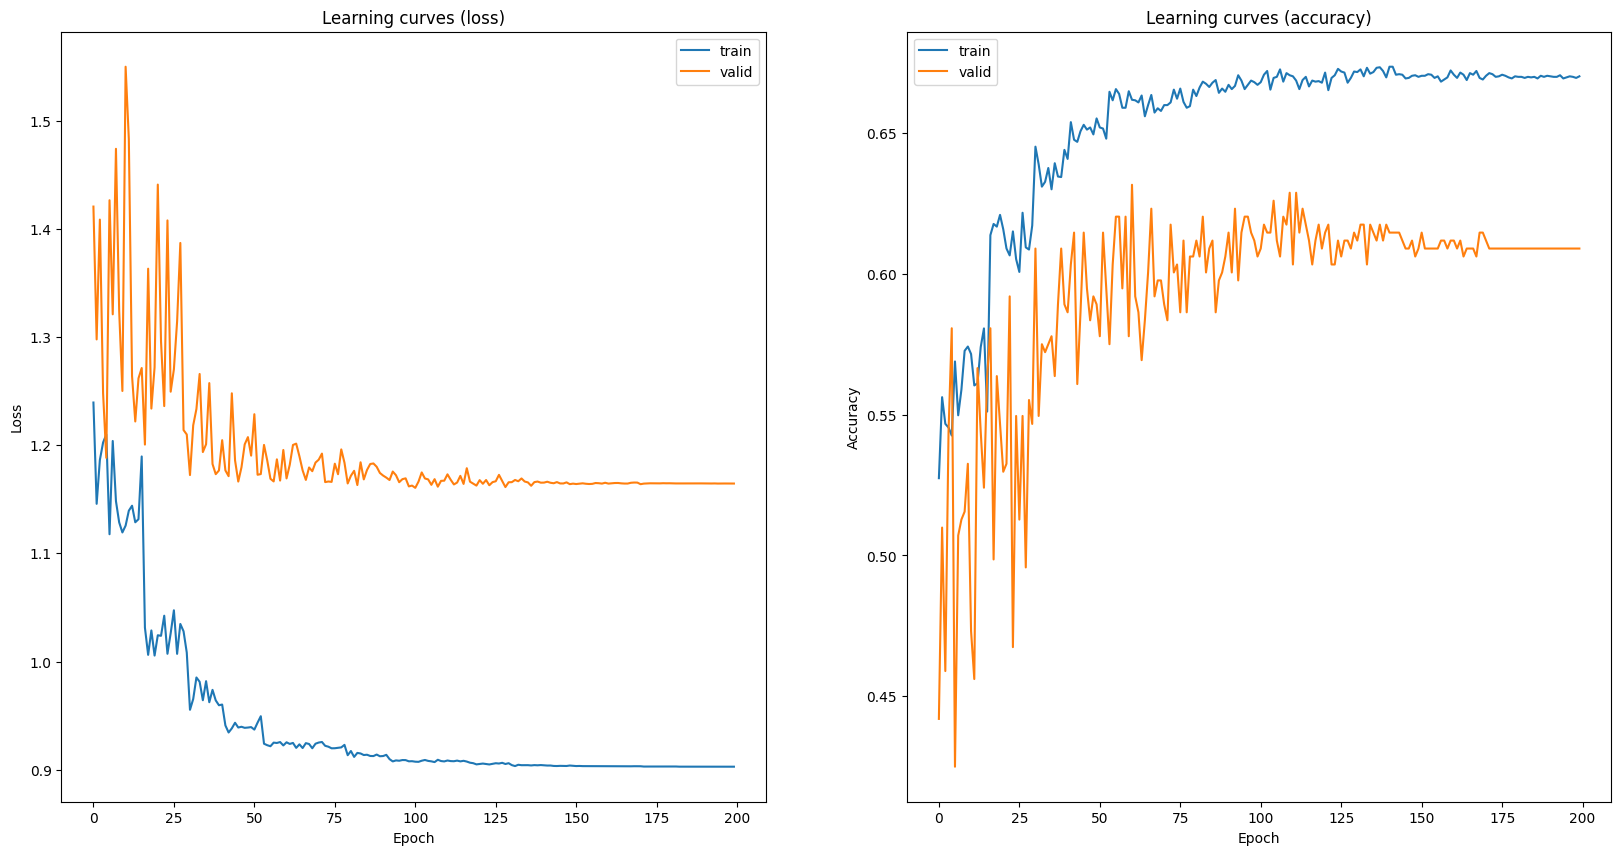

In [26]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

ax = figure.add_subplot(1, 2, 2, title='Learning curves (accuracy)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'valid')
ax.legend()

plt.show()

The final result is okay. Though no better than the basic convolutional network.

In [27]:
train_eval = cnn.evaluate(X_train, y_train)
validation_eval = cnn.evaluate(X_valid, y_valid)
test_eval = cnn.evaluate(X_test, y_test)
print("Error on test data: {p:.2f}%".format(p = 100*(1-test_eval[1])))

15/15 [==============================] - 1s 32ms/step - loss: 1.0846 - accuracy: 0.6170
Error on test data: 38.30%
